# SGD Noise, Learning-Rate Schedules, and Batch-Size Strategies
## Logistic regression on a synthetic ill-conditioned dataset

In this notebook we study **optimization dynamics** in a controlled setting:
regularized logistic regression trained with stochastic gradient descent (SGD).

We will investigate:
- small vs medium vs large batches
- fixed learning rate vs polynomial decay
- gradually increasing the batch size during training

### Two diagnostics tracked per epoch
1. **Suboptimality:**  \( f(\theta_k) - f(\theta^\*) \)
2. **Search-direction variance:** a dimensionless measure of how noisy the minibatch directions are

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# ---------------------------
# Teaching knob: fast runs
# ---------------------------
FAST_MODE = True
if FAST_MODE:
    EPOCHS = 800     # use 5000 for paper-quality plots
else:
    EPOCHS = 5000

ETA0 = 1e-3
LAMBDA = 1e-4


## 2. Synthetic dataset with ill-conditioned features

We generate:
- features $X \in \mathbb{R}^{n \times d}$ from a standard normal distribution
- then rescale each feature dimension with logarithmically spaced factors

This creates strong anisotropy in the geometry of the loss landscape, which makes
optimization behavior more interesting and closer to realistic ML setups.

In [3]:
def make_synthetic_logistic(n=5000, d=40, seed=0):
    rng = np.random.default_rng(seed)

    X = rng.normal(size=(n, d))
    scales = np.logspace(0, 3, d)   # from 1 to 1000
    X = X * scales

    w_true = rng.normal(size=d)
    logits = X @ w_true
    p = 1.0 / (1.0 + np.exp(-logits))
    y = rng.binomial(1, p)

    return X.astype(np.float64), y.astype(np.int32), w_true

X, y, w_true = make_synthetic_logistic(n=6000, d=20, seed=0)
print("X shape:", X.shape, "| y shape:", y.shape)
print("y mean (class balance):", y.mean())

X shape: (6000, 20) | y shape: (6000,)
y mean (class balance): 0.49266666666666664


/var/folders/pv/7xq94jdd4d51wrjpm4h32qj00000gn/T/ipykernel_30010/2147005568.py:10: RuntimeWarning: overflow encountered in exp
  p = 1.0 / (1.0 + np.exp(-logits))


## 3. Objective: regularized logistic regression

We minimize:
$
f(w) = \frac{1}{n}\sum_{i=1}^n \ell(\langle x_i, w\rangle, y_i) \;+\; \frac{\lambda}{2}\|w\|^2,
$
where $\ell$ is the logistic loss.

We implement:
- stable sigmoid
- loss
- gradient
- Hessian (used only if we want a Newton reference solution)

In [4]:
def sigmoid(z):
    z = z.astype(np.float64, copy=False)
    out = np.empty_like(z, dtype=np.float64)
    pos = (z >= 0)
    neg = ~pos
    out[pos] = 1.0 / (1.0 + np.exp(-z[pos]))
    ez = np.exp(z[neg])
    out[neg] = ez / (1.0 + ez)
    return out

def logloss(w, X, y, lam=1e-4):
    z = X @ w
    p = sigmoid(z)
    eps = 1e-12
    loss = -np.mean(y * np.log(p+eps) + (1-y)*np.log(1-p+eps))
    loss += 0.5 * lam * np.sum(w**2)
    return float(loss)

def grad_logloss(w, X, y, lam=1e-4):
    z = X @ w
    p = sigmoid(z)
    grad = (X.T @ (p - y)) / X.shape[0]
    grad += lam * w
    return grad.astype(np.float64)

def hess_logloss_full(w, X, y, lam=1e-4, damping=1e-8):
    n, d = X.shape
    z = X @ w
    p = sigmoid(z)
    w_diag = p*(1-p)                  # (n,)
    WX = X * w_diag[:, None]          # (n,d)
    H = (X.T @ WX) / n                # (d,d)
    H = H + lam * np.eye(d) + damping * np.eye(d)
    return H

## 4. Reference optimum $f(\theta^\ast)$

To measure suboptimality, we need a reference value $f^\ast$.
In research code, we can compute it via Newton's method.
For speed, we can hard-code a precomputed value to save time.

Below:
- we keep the precomputed value (fast)
- and optionally provide Newton solve (slow)

In [5]:
# Fast option: use precomputed f_opt
f_opt = 1.101595433540e-03
print("Using precomputed f_opt =", f_opt)


def newton_solve_opt(X, y, lam=1e-4, tol=1e-10, max_iter=50):
    d = X.shape[1]
    w = np.zeros(d)

    for it in range(max_iter):
        g = grad_logloss(w, X, y, lam)
        ng = np.linalg.norm(g)
        if ng < tol:
            print(f"[Newton] Converged in {it} iterations | ||g||={ng:.2e}")
            break

        H = hess_logloss_full(w, X, y, lam)
        step = np.linalg.solve(H, g)
        w = w - step

    f_star = logloss(w, X, y, lam)
    print(f"[Newton] f* = {f_star:.12e}")
    return w, f_star

# Uncomment to recompute  f_opt (slow, but nexessary if data, or reg. parameter changes)
# w_star, f_opt = newton_solve_opt(X, y, lam=LAMBDA)

Using precomputed f_opt = 0.00110159543354


## 5. A diagnostic for SGD noise: direction variance

Within each epoch, SGD produces a sequence of update directions \(d_1, \dots, d_M\)
(one per mini-batch). We measure how noisy these directions are by:

\[
\text{dir\_var}
\;=\;
\frac{\mathbb{E}\|d_i - \bar d\|^2}{\|\bar d\|^2},
\qquad \bar d = \mathbb{E}[d_i].
\]

Interpretation:
- small dir_var  → mini-batch directions agree (low stochastic noise)
- large dir_var  → directions are highly variable (noisy dynamics)

In [6]:
def poly_scheduler(epoch, eta0, decay=5e-3, power=1):
    return eta0 / ((1 + decay * epoch) ** power)

## 7. SGD runner (fixed batch size)

We implement full-epoch SGD:
- shuffle dataset each epoch
- loop over mini-batches and update parameters
- track per epoch:
  - loss
  - suboptimality
  - direction variance

In [7]:
def run_sgd(
    X, y, lam=1e-4,
    epochs=300, batch_size=8,
    eta0=1e-3, scheduler=None,
    seed=0, f_opt=None
):
    n, d = X.shape
    rng = np.random.default_rng(seed)
    w = np.zeros(d)

    hist_loss, hist_subopt, hist_var, hist_epoch = [], [], [], []

    for ep in range(epochs):
        lr = eta0 if scheduler is None else scheduler(ep, eta0)

        idx = rng.permutation(n)
        Xs, ys = X[idx], y[idx]

        dirs = []
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            g = grad_logloss(w, Xs[start:end], ys[start:end], lam)
            d_step = -lr * g
            dirs.append(d_step)
            w = w + d_step

        f = logloss(w, X, y, lam)
        hist_loss.append(f)
        hist_subopt.append(f - f_opt)
        hist_epoch.append(ep)

        D = np.stack(dirs, axis=0)
        mean_d = D.mean(axis=0)
        diff = D - mean_d
        num = np.mean(np.sum(diff * diff, axis=1))
        denom = np.linalg.norm(mean_d) ** 2 + 1e-12
        hist_var.append(num / denom)

    return {
        "epoch": np.array(hist_epoch),
        "loss": np.array(hist_loss),
        "subopt": np.array(hist_subopt),
        "dir_var": np.array(hist_var),
    }

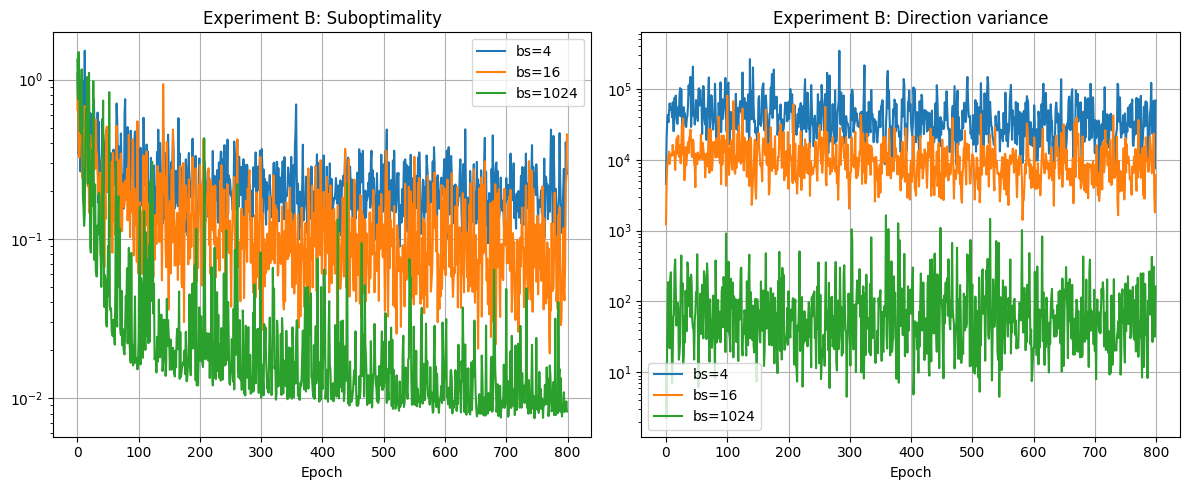

In [9]:
bs_list = [4, 16, 1024]
histories_B = {}

for bs in bs_list:
    h = run_sgd(
        X, y, lam=LAMBDA,
        epochs=EPOCHS, batch_size=bs,
        eta0=ETA0, scheduler=None,
        seed=0, f_opt=f_opt
    )
    histories_B[bs] = h
    pd.DataFrame(h).assign(batch_size=bs).to_csv(
        f"csv_synthetic/expB_bs{bs}.csv", index=False
    )

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
for bs in bs_list:
    plt.semilogy(histories_B[bs]["epoch"], histories_B[bs]["subopt"], label=f"bs={bs}")
plt.title("Suboptimality")
plt.xlabel("Epoch")
plt.grid(True); plt.legend()

plt.subplot(1,2,2)
for bs in bs_list:
    plt.semilogy(histories_B[bs]["epoch"], histories_B[bs]["dir_var"], label=f"bs={bs}")
plt.title("Direction variance")
plt.xlabel("Epoch")
plt.grid(True); plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
bsA = 16

hist_fixed = run_sgd(
    X, y, lam=LAMBDA,
    epochs=EPOCHS, batch_size=bsA,
    eta0=ETA0, scheduler=None,
    seed=0, f_opt=f_opt
)

hist_sched = run_sgd(
    X, y, lam=LAMBDA,
    epochs=EPOCHS, batch_size=bsA,
    eta0=ETA0,
    scheduler=lambda ep, e0: poly_scheduler(ep, e0, decay=0.02),
    seed=0, f_opt=f_opt
)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.semilogy(hist_fixed["epoch"], hist_fixed["subopt"], label="fixed LR")
plt.semilogy(hist_sched["epoch"], hist_sched["subopt"], label="poly scheduler")
plt.title("Experiment A: Suboptimality")
plt.xlabel("Epoch")
plt.grid(True); plt.legend()

plt.subplot(1,2,2)
plt.semilogy(hist_fixed["epoch"], hist_fixed["dir_var"], label="fixed LR")
plt.semilogy(hist_sched["epoch"], hist_sched["dir_var"], label="poly scheduler")
plt.title("Experiment A: Direction variance")
plt.xlabel("Epoch")
plt.grid(True); plt.legend()

plt.tight_layout()
plt.show()

## 8. Progressive batch size

A common strategy is to start with small batches (cheap, noisy updates)
and gradually increase batch size (more accurate updates).

We implement a linear schedule from `bs_start` to `bs_end`.

In [8]:
def run_sgd_progressive(
    X, y, lam=1e-4,
    epochs=300,
    bs_start=8, bs_end=512,
    eta0=1e-3, seed=0, f_opt=None
):
    n, d = X.shape
    rng = np.random.default_rng(seed)
    w = np.zeros(d)

    hist_loss, hist_subopt, hist_var, hist_epoch = [], [], [], []

    for ep in range(epochs):
        frac = ep / (epochs - 1) if epochs > 1 else 1.0
        bs = int(bs_start + frac * (bs_end - bs_start))
        bs = max(1, min(bs, n))

        idx = rng.permutation(n)
        Xs, ys = X[idx], y[idx]

        dirs = []
        for start in range(0, n, bs):
            end = min(start + bs, n)
            g = grad_logloss(w, Xs[start:end], ys[start:end], lam)
            d_step = -eta0 * g
            dirs.append(d_step)
            w = w + d_step

        f = logloss(w, X, y, lam)
        hist_loss.append(f)
        hist_subopt.append(f - f_opt)
        hist_epoch.append(ep)

        D = np.stack(dirs, axis=0)
        mean_d = D.mean(axis=0)
        diff = D - mean_d
        num = np.mean(np.sum(diff * diff, axis=1))
        denom = np.linalg.norm(mean_d) ** 2 + 1e-12
        hist_var.append(num / denom)

    return {
        "epoch": np.array(hist_epoch),
        "loss": np.array(hist_loss),
        "subopt": np.array(hist_subopt),
        "dir_var": np.array(hist_var),
    }

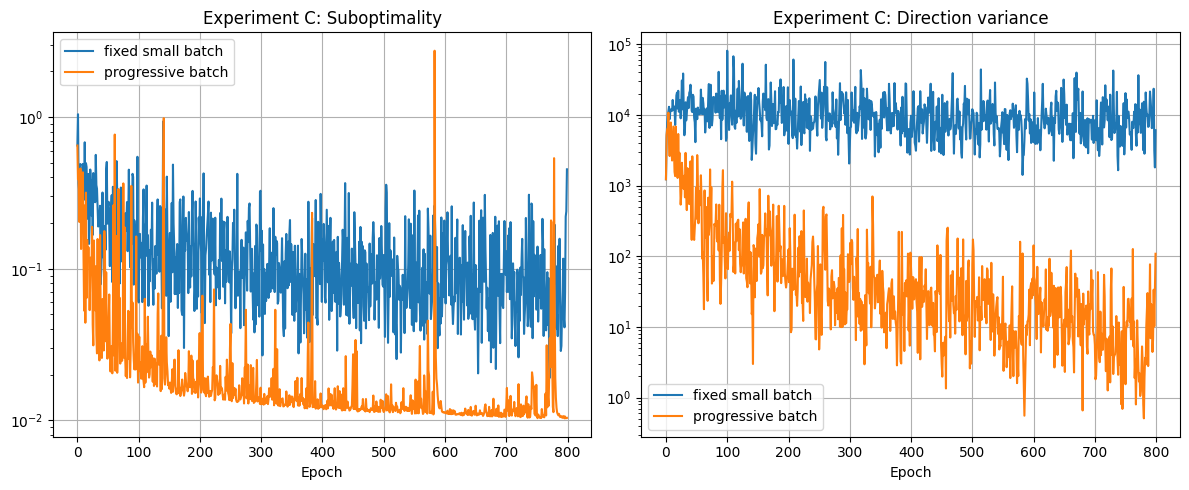

In [12]:
bs_start, bs_end = 16, 2048

hist_fixedC = run_sgd(
    X, y, lam=LAMBDA,
    epochs=EPOCHS, batch_size=bs_start,
    eta0=ETA0, scheduler=None,
    seed=0, f_opt=f_opt
)

hist_prog = run_sgd_progressive(
    X, y, lam=LAMBDA,
    epochs=EPOCHS,
    bs_start=bs_start, bs_end=bs_end,
    eta0=ETA0,
    seed=0, f_opt=f_opt
)

pd.DataFrame(hist_fixedC).assign(mode="fixed").to_csv(
    "csv_synthetic/expC_fixed.csv", index=False
)
pd.DataFrame(hist_prog).assign(mode="progressive").to_csv(
    "csv_synthetic/expC_progressive.csv", index=False
)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.semilogy(hist_fixedC["epoch"], hist_fixedC["subopt"], label="fixed small batch")
plt.semilogy(hist_prog["epoch"], hist_prog["subopt"], label="progressive batch")
plt.title("Experiment C: Suboptimality")
plt.xlabel("Epoch")
plt.grid(True); plt.legend()

plt.subplot(1,2,2)
plt.semilogy(hist_fixedC["epoch"], hist_fixedC["dir_var"], label="fixed small batch")
plt.semilogy(hist_prog["epoch"], hist_prog["dir_var"], label="progressive batch")
plt.title("Experiment C: Direction variance")
plt.xlabel("Epoch")
plt.grid(True); plt.legend()

plt.tight_layout()
plt.show()

# Discussion and Takeaways

### Experiment 1 (batch size)
- Small batch → cheap updates, high direction variance (noisy dynamics)
- Large batch → stable directions, but fewer updates per epoch and potentially slower exploration

### Experiment 2 (schedule)
A decaying learning rate often reduces noise and improves long-run convergence,
at the cost of slower early progress.

### Experiment 3 (progressive batch)
A progressive schedule attempts to combine the best of both:
- early exploration with small batches,
- late-stage refinement with large batches.

This strategy is frequently used in large-scale ML training.